# Blackjack Card Point Detection Project 🃏

This notebook guides you through building a card recognition system for blackjack.
You upload a photo of a blackjack game, and the system will:
- Detect each card
- Recognize its number (A–K)
- Group cards by player
- Count points based on blackjack rules
- Decide who won

🟩 Subtask 1: Import Required Libraries
Goal: Load all Python libraries you'll use.

Explanation:
You need libraries like:

cv2 (OpenCV) for image processing,

numpy for numerical operations,

matplotlib.pyplot to visualize steps,

glob and os to load template files.

In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.patches import Rectangle

# Display settings for better visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gray'

print("All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

#code for subtask 1 here

All libraries imported successfully!
OpenCV version: 4.11.0
NumPy version: 2.2.6


🟩 Subtask 2: Load and Preprocess the Input Image
Goal: Read cards.png and make it easier to detect cards.

Explanation:

Convert to grayscale → easier processing.

Apply Gaussian blur → reduce noise.

Use Canny edge detection → highlight edges of the cards.

This prepares the image for finding contours.

Image loaded successfully! Shape: (558, 960, 3)


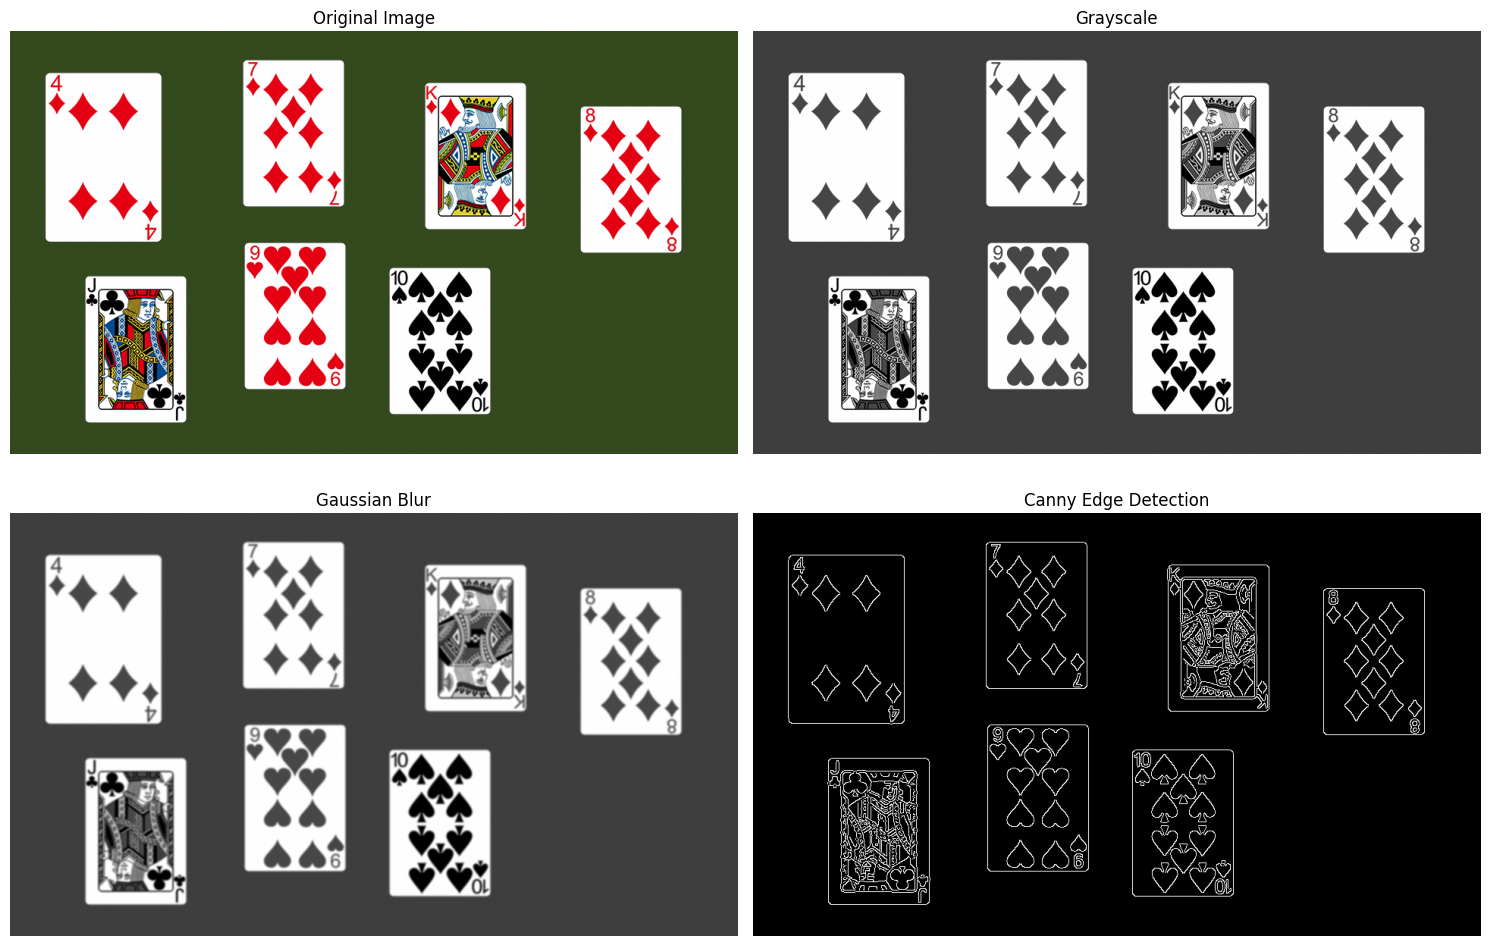

Preprocessing completed successfully!
Original image shape: (558, 960, 3)
Grayscale shape: (558, 960)
Edge detection ready for contour finding


In [99]:
import cv2
import matplotlib.pyplot as plt

# Load the input image
image_path = 'cards2.png'
original_image = cv2.imread(image_path)

if original_image is None:
    print(f"Error: Could not load image from {image_path}")
    print("Make sure the cards.png file is in the current directory")
else:
    print(f"Image loaded successfully! Shape: {original_image.shape}")
    
    # Convert BGR to RGB for matplotlib display
    original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale for processing
    gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Display the preprocessing steps
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].imshow(original_rgb)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(gray, cmap='gray')
    axes[0, 1].set_title('Grayscale')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(blurred, cmap='gray')
    axes[1, 0].set_title('Gaussian Blur')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(edges, cmap='gray')
    axes[1, 1].set_title('Canny Edge Detection')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Preprocessing completed successfully!")
    print(f"Original image shape: {original_image.shape}")
    print(f"Grayscale shape: {gray.shape}")
    print(f"Edge detection ready for contour finding")

🟩 Subtask 3: Detect Individual Cards Using Contours
Goal: Find and extract the rectangular outlines of each card.

Explanation:

Use cv2.findContours() to find all contours.

Filter for contours that:

Have 4 corners (i.e., rectangles),

Have a large enough area (to ignore noise).

This step gives you the bounding box for each card in the image.

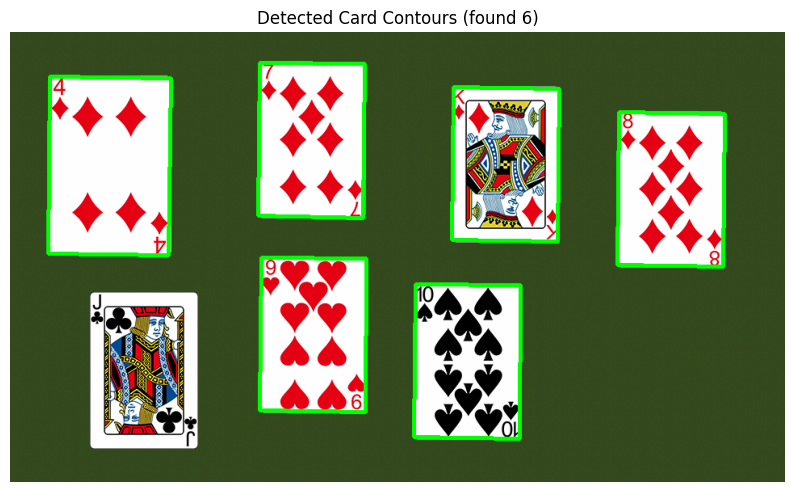

Number of card-like contours detected: 6


In [100]:
# Detect contours in the edge image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

card_contours = []
min_area = 10000  # Minimum area to filter out noise (adjust as needed)

for cnt in contours:
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    if len(approx) == 4 and cv2.contourArea(cnt) > min_area:
        card_contours.append(approx)

# Draw detected card contours on a copy of the original image
contour_img = original_rgb.copy()
for cnt in card_contours:
    cv2.drawContours(contour_img, [cnt], -1, (0, 255, 0), 4)

plt.figure(figsize=(10, 8))
plt.imshow(contour_img)
plt.title(f'Detected Card Contours (found {len(card_contours)})')
plt.axis('off')
plt.show()

print(f"Number of card-like contours detected: {len(card_contours)}")
# card_contours now contains the 4-point contours for each detected card

🟩 Subtask 4: Sort Cards Left-to-Right (Optional but Recommended)
Goal: Ensure consistent card order.

Explanation:

Use the x-position of each card's bounding box to sort them.

Helps with debugging, and makes the output predictable.

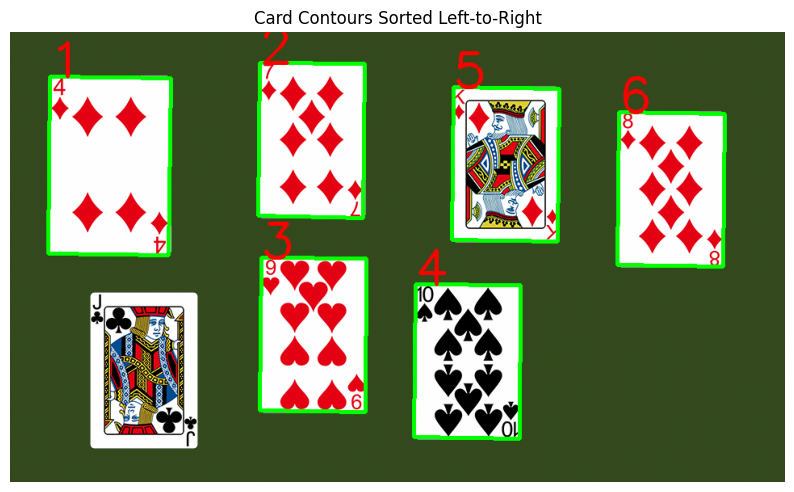

Card contours sorted left-to-right.


In [101]:
# Sort card contours left-to-right by the x-coordinate of their top-left corner
def get_leftmost_point(contour):
    # contour shape: (4, 1, 2)
    pts = contour.reshape(4, 2)
    return np.min(pts[:, 0])

card_contours = sorted(card_contours, key=get_leftmost_point)

# Visualize the sorted order by numbering the cards
sorted_img = original_rgb.copy()
for idx, cnt in enumerate(card_contours):
    cv2.drawContours(sorted_img, [cnt], -1, (0, 255, 0), 4)
    # Find the top-left point for placing the number
    pts = cnt.reshape(4, 2)
    top_left = pts[np.argmin(pts[:, 0] + pts[:, 1])]
    cv2.putText(sorted_img, str(idx+1), tuple(top_left), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 4)

plt.figure(figsize=(10, 8))
plt.imshow(sorted_img)
plt.title('Card Contours Sorted Left-to-Right')
plt.axis('off')
plt.show()

print('Card contours sorted left-to-right.')
# card_contours is now sorted for further processing

🟩 Subtask 5: Warp Each Card to a Standard Size
Goal: Get a clean top-down view of each card regardless of angle.

Explanation:

Use the 4-point perspective transform to "flatten" each card.

This ensures that the position and size of the rank symbol will be consistent, making the next steps more accurate.

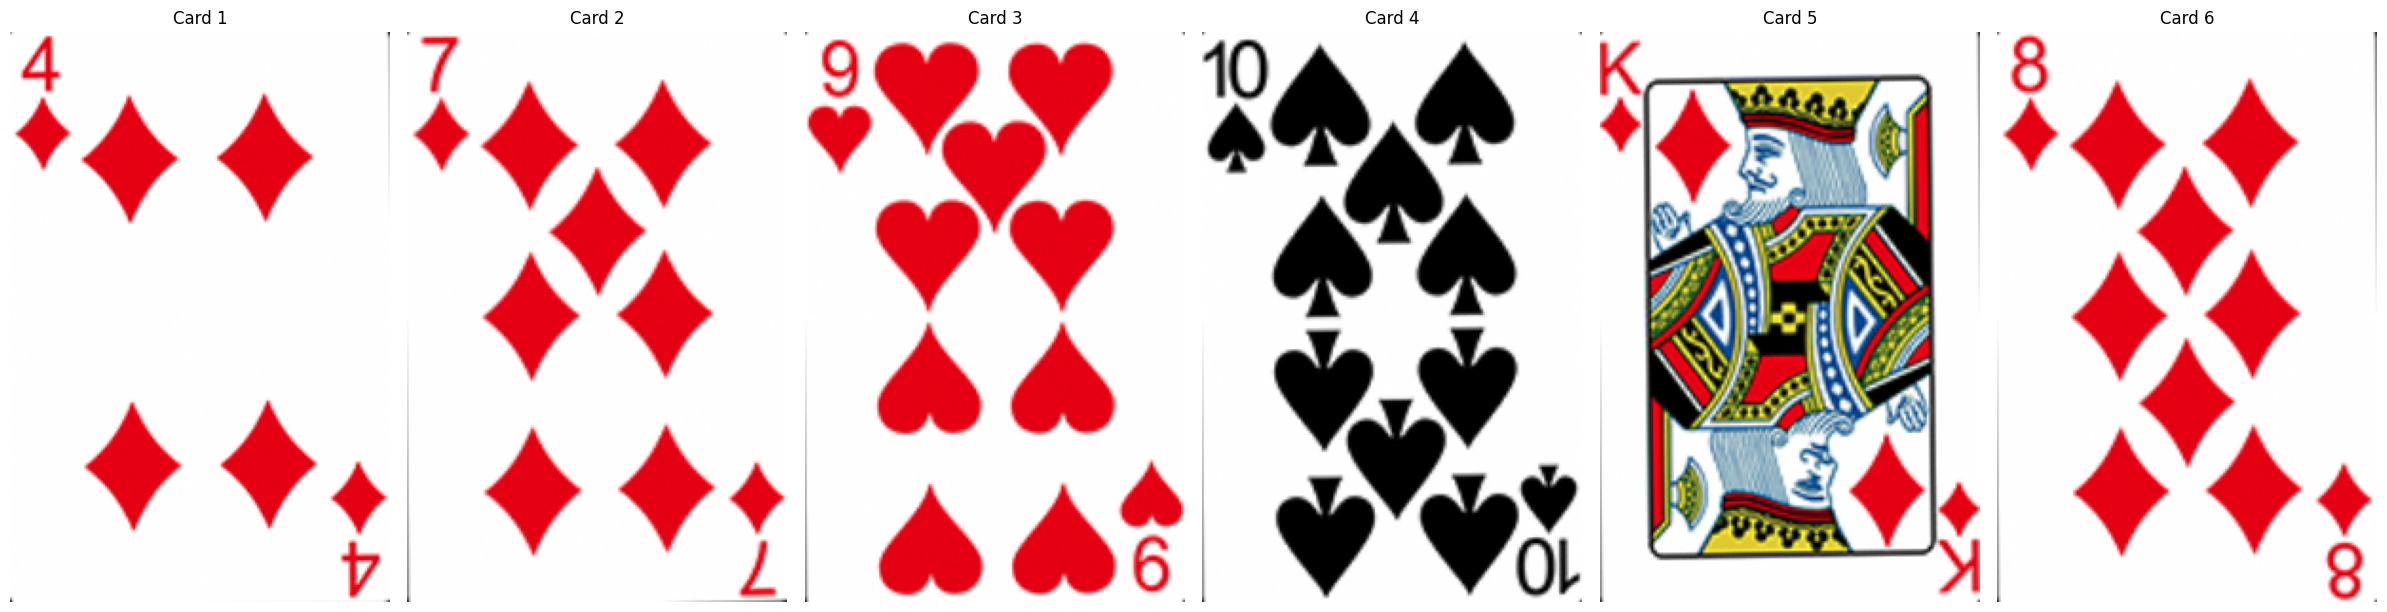

Warped 6 cards to a standard size (200x300 pixels).


In [102]:
# Subtask 5: Warp Each Card to a Standard Size

def order_points(pts):
    # Order points: top-left, top-right, bottom-right, bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts, width=200, height=300):
    rect = order_points(pts)
    dst = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (width, height))
    return warped

# Warp each detected card to a standard size
warped_cards = []
for idx, cnt in enumerate(card_contours):
    pts = cnt.reshape(4, 2)
    warped = four_point_transform(original_image, pts)
    warped_cards.append(warped)

# Visualize the warped cards
fig, axes = plt.subplots(1, len(warped_cards), figsize=(4 * len(warped_cards), 6))
if len(warped_cards) == 1:
    axes = [axes]
for i, card in enumerate(warped_cards):
    axes[i].imshow(cv2.cvtColor(card, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Card {i+1}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print(f"Warped {len(warped_cards)} cards to a standard size (200x300 pixels).")

🟩 Subtask 6: Prepare Cards for Template Matching
Goal: Prepare the warped cards for full-card template matching.

Explanation:

We'll now compare the entire card against template images.

Convert each warped card to grayscale for consistent comparison.

Apply preprocessing to enhance matching accuracy.

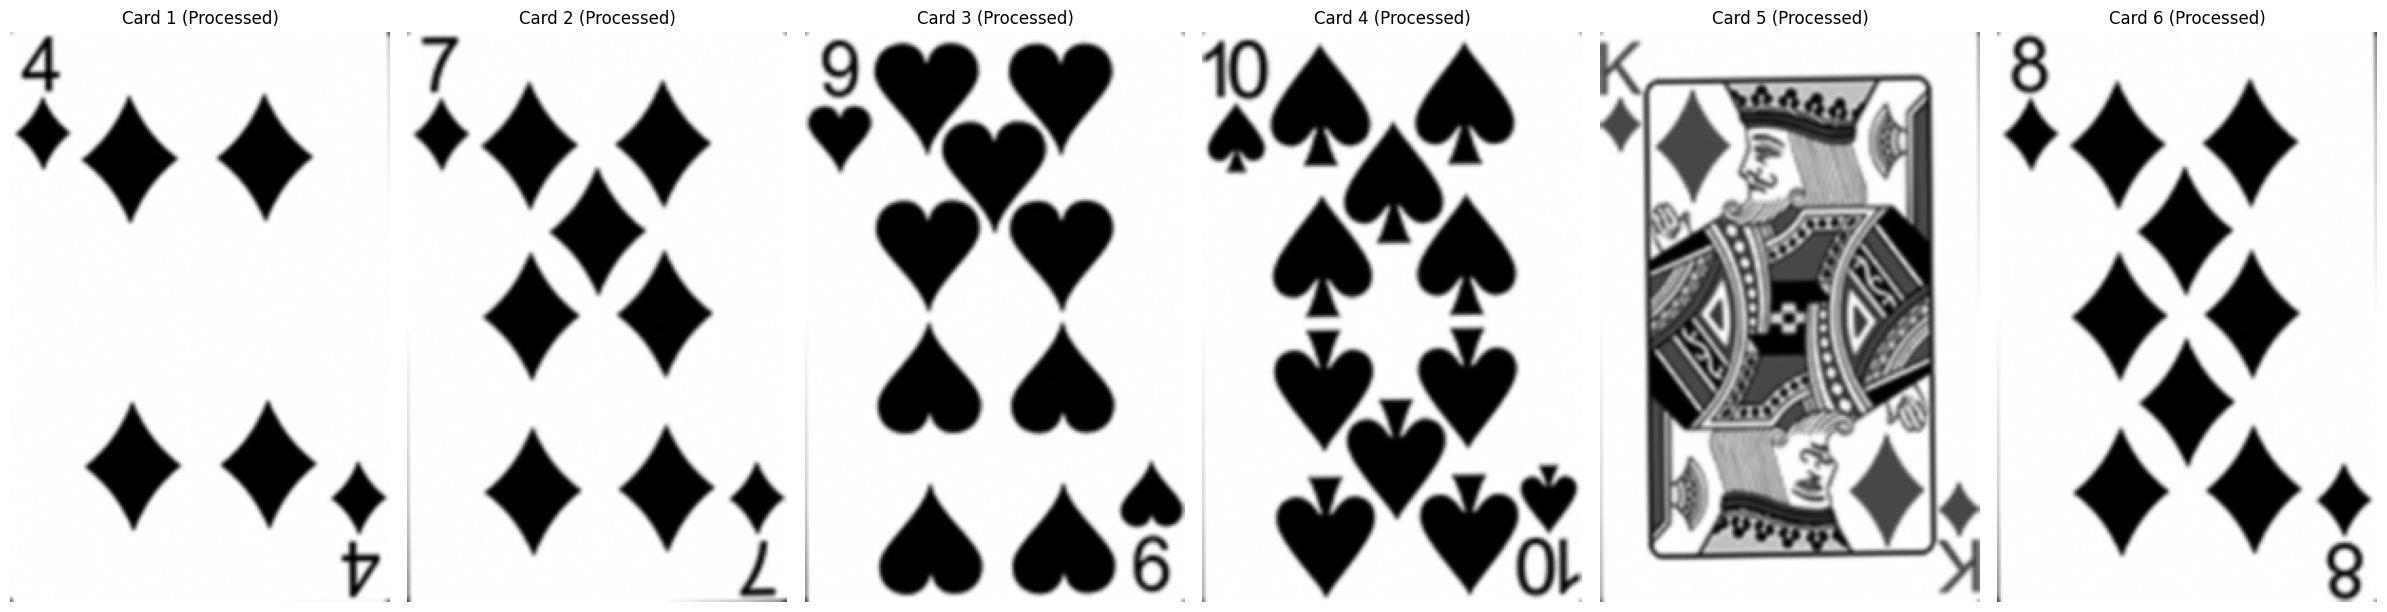

Processed 6 cards for whole-card template matching.


In [103]:
# Subtask 6: Prepare Cards for Template Matching
processed_cards = []
for idx, card in enumerate(warped_cards):
    # Convert to grayscale for template matching
    card_gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    card_blurred = cv2.GaussianBlur(card_gray, (3, 3), 0)
    
    processed_cards.append(card_blurred)

# Visualize the processed cards
fig, axes = plt.subplots(1, len(processed_cards), figsize=(4 * len(processed_cards), 6))
if len(processed_cards) == 1:
    axes = [axes]
for i, card in enumerate(processed_cards):
    axes[i].imshow(card, cmap='gray')
    axes[i].set_title(f'Card {i+1} (Processed)')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print(f"Processed {len(processed_cards)} cards for whole-card template matching.")

🟩 Subtask 7: Load Card Templates from PNG-cards Folder
Goal: Load all card template images for whole-card comparison.

Explanation:

Load card images from PNG-cards/ folder with names like "rank_of_suit.png".

Handle special cases (ace_of_spades2, jack/queen/king variants with "2" suffix).

Resize templates to match warped card size and preprocess them.

Loaded card templates for 13 ranks:
  2: 4 template variations
  3: 4 template variations
  4: 4 template variations
  5: 4 template variations
  6: 4 template variations
  7: 4 template variations
  8: 4 template variations
  9: 4 template variations
  10: 4 template variations
  A: 5 template variations
  J: 8 template variations
  Q: 8 template variations
  K: 8 template variations


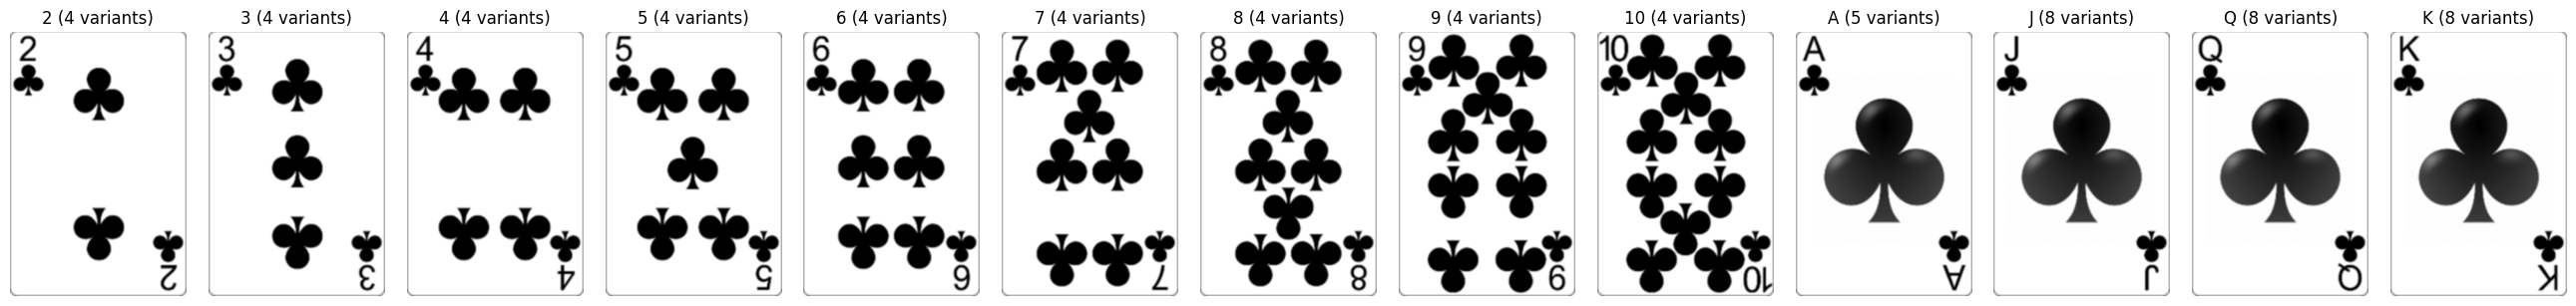


Total templates loaded: 65


In [104]:
# Subtask 7: Load Card Templates from PNG-cards Folder
card_templates = {}
template_dir = 'PNG-cards/'

# Define all possible card combinations
ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'ace', 'jack', 'queen', 'king']
suits = ['clubs', 'diamonds', 'hearts', 'spades']

# Load all card templates
for rank in ranks:
    for suit in suits:
        # Standard naming convention
        template_name = f'{rank}_of_{suit}.png'
        template_path = os.path.join(template_dir, template_name)
        
        if os.path.exists(template_path):
            template_img = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
            # Resize to match warped card size (200x300)
            template_img = cv2.resize(template_img, (200, 300))
            # Apply same preprocessing as cards
            template_blurred = cv2.GaussianBlur(template_img, (3, 3), 0)
            
            # Store with simplified key for blackjack (rank only)
            if rank == 'ace':
                key = 'A'
            elif rank == 'jack':
                key = 'J'
            elif rank == 'queen':
                key = 'Q'
            elif rank == 'king':
                key = 'K'
            else:
                key = rank
            
            # Store multiple templates for each rank (different suits and variants)
            if key not in card_templates:
                card_templates[key] = []
            card_templates[key].append(template_blurred)
        
        # Check for variant templates (jack2, queen2, king2, ace_of_spades2)
        if rank in ['jack', 'queen', 'king'] or (rank == 'ace' and suit == 'spades'):
            variant_name = f'{rank}_of_{suit}2.png' if rank != 'ace' else 'ace_of_spades2.png'
            variant_path = os.path.join(template_dir, variant_name)
            
            if os.path.exists(variant_path):
                variant_img = cv2.imread(variant_path, cv2.IMREAD_GRAYSCALE)
                variant_img = cv2.resize(variant_img, (200, 300))
                variant_blurred = cv2.GaussianBlur(variant_img, (3, 3), 0)
                
                # Add to the same rank category
                if rank == 'ace':
                    key = 'A'
                elif rank == 'jack':
                    key = 'J'
                elif rank == 'queen':
                    key = 'Q'
                elif rank == 'king':
                    key = 'K'
                
                if key not in card_templates:
                    card_templates[key] = []
                card_templates[key].append(variant_blurred)

# Display summary
print(f"Loaded card templates for {len(card_templates)} ranks:")
for rank, templates in card_templates.items():
    print(f"  {rank}: {len(templates)} template variations")

# Visualize one template per rank
fig, axes = plt.subplots(1, len(card_templates), figsize=(2 * len(card_templates), 3))
if len(card_templates) == 1:
    axes = [axes]

for i, (rank, templates) in enumerate(card_templates.items()):
    axes[i].imshow(templates[0], cmap='gray')  # Show first template for each rank
    axes[i].set_title(f'{rank} ({len(templates)} variants)')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print(f"\nTotal templates loaded: {sum(len(templates) for templates in card_templates.values())}")

🟩 Subtask 8: Whole Card Template Matching
Goal: Match each detected card against all template cards.

Explanation:

Compare the entire warped card against all template variations.

Use multiple similarity metrics for robust matching.

Find the best matching rank across all template variations.

In [105]:
# Advanced Whole Card Template Matching
import numpy as np
import cv2

# 1. Normalized Cross Correlation
def correlation_score(card_img, template_img):
    result = cv2.matchTemplate(card_img, template_img, cv2.TM_CCOEFF_NORMED)
    return max(0, result[0, 0])  # Ensure non-negative

# 2. Structural Similarity (SSIM-like)
def structural_similarity_score(card_img, template_img):
    # Simple structural similarity based on gradients
    card_grad_x = cv2.Sobel(card_img, cv2.CV_64F, 1, 0, ksize=3)
    card_grad_y = cv2.Sobel(card_img, cv2.CV_64F, 0, 1, ksize=3)
    template_grad_x = cv2.Sobel(template_img, cv2.CV_64F, 1, 0, ksize=3)
    template_grad_y = cv2.Sobel(template_img, cv2.CV_64F, 0, 1, ksize=3)
    
    card_grad = np.sqrt(card_grad_x**2 + card_grad_y**2)
    template_grad = np.sqrt(template_grad_x**2 + template_grad_y**2)
    
    # Normalize gradients
    card_grad = card_grad / (np.max(card_grad) + 1e-8)
    template_grad = template_grad / (np.max(template_grad) + 1e-8)
    
    # Calculate similarity
    diff = np.abs(card_grad - template_grad)
    similarity = 1 - np.mean(diff)
    return max(0, similarity)

# 3. Histogram-based similarity
def histogram_score(card_img, template_img):
    # Calculate histograms
    hist1 = cv2.calcHist([card_img], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([template_img], [0], None, [256], [0, 256])
    
    # Normalize histograms
    hist1 = hist1 / (np.sum(hist1) + 1e-8)
    hist2 = hist2 / (np.sum(hist2) + 1e-8)
    
    # Calculate correlation
    correlation = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return max(0, correlation)

# 4. Combined scoring function for whole cards
def combined_card_score(card_img, template_img):
    # Get individual scores
    corr_score = correlation_score(card_img, template_img)
    struct_score = structural_similarity_score(card_img, template_img)
    hist_score = histogram_score(card_img, template_img)
    
    # Weighted combination
    weights = [0.5, 0.3, 0.2]  # [correlation, structural, histogram]
    combined = weights[0] * corr_score + weights[1] * struct_score + weights[2] * hist_score
    
    return combined, {'corr': corr_score, 'struct': struct_score, 'hist': hist_score}

# Perform whole card template matching
match_results = []
for idx, card_img in enumerate(processed_cards):
    best_rank = None
    best_score = -1
    best_details = None
    rank_scores = {}
    
    # Test against all templates for each rank
    for rank, templates in card_templates.items():
        max_score_for_rank = -1
        best_details_for_rank = None
        
        # Try all template variations for this rank
        for template in templates:
            combined_score, details = combined_card_score(card_img, template)
            
            if combined_score > max_score_for_rank:
                max_score_for_rank = combined_score
                best_details_for_rank = details
        
        rank_scores[rank] = max_score_for_rank
        
        if max_score_for_rank > best_score:
            best_score = max_score_for_rank
            best_rank = rank
            best_details = best_details_for_rank
    
    # Sort all ranks by score for top-3
    sorted_scores = sorted(rank_scores.items(), key=lambda x: x[1], reverse=True)
    top3 = sorted_scores[:3]
    
    match_results.append({
        'best_rank': best_rank,
        'best_score': best_score,
        'top3': top3,
        'details': best_details
    })

print("Whole card template matching complete for all cards.")
print("Using: Normalized Cross-Correlation + Structural Similarity + Histogram Matching")

Whole card template matching complete for all cards.
Using: Normalized Cross-Correlation + Structural Similarity + Histogram Matching


🟩 Subtask 9: Store & Print Match Results
Goal: Track what each card was classified as.

Explanation:

For each card, save its predicted rank and match confidence.

Optionally, print or visualize top matches for debugging.

In [106]:
# code for subtask 9
# Subtask 9: Store & Print Match Results - Enhanced

print("🎯 Enhanced Match Results for Each Card:\n")
print("=" * 60)

for idx, result in enumerate(match_results):
    print(f"\n📊 Card {idx+1}:")
    print(f"   🏆 Predicted Rank: {result['best_rank']} (Overall: {result['best_score']*100:.1f}%)")
    
    # Show score breakdown for best match
    details = result['details']
    print(f"   📈 Score Breakdown:")
    print(f"      • Correlation: {details['corr']*100:.1f}%")
    
    print(f"   🥇 Top 3 Matches:")
    for i, (rank, score) in enumerate(result['top3']):
        medal = ["🥇", "🥈", "🥉"][i]
        print(f"      {medal} {rank}: {score*100:.1f}%")
    print("-" * 40)

print("\n✅ Multi-metric matching complete!")

🎯 Enhanced Match Results for Each Card:


📊 Card 1:
   🏆 Predicted Rank: 4 (Overall: 84.7%)
   📈 Score Breakdown:
      • Correlation: 89.4%
   🥇 Top 3 Matches:
      🥇 4: 84.7%
      🥈 5: 79.5%
      🥉 6: 68.9%
----------------------------------------

📊 Card 2:
   🏆 Predicted Rank: 7 (Overall: 84.9%)
   📈 Score Breakdown:
      • Correlation: 91.4%
   🥇 Top 3 Matches:
      🥇 7: 84.9%
      🥈 8: 81.0%
      🥉 6: 76.4%
----------------------------------------

📊 Card 3:
   🏆 Predicted Rank: 9 (Overall: 83.2%)
   📈 Score Breakdown:
      • Correlation: 92.6%
   🥇 Top 3 Matches:
      🥇 9: 83.2%
      🥈 10: 78.8%
      🥉 7: 57.3%
----------------------------------------

📊 Card 4:
   🏆 Predicted Rank: 10 (Overall: 85.9%)
   📈 Score Breakdown:
      • Correlation: 91.5%
   🥇 Top 3 Matches:
      🥇 10: 85.9%
      🥈 9: 82.1%
      🥉 8: 58.6%
----------------------------------------

📊 Card 5:
   🏆 Predicted Rank: K (Overall: 79.5%)
   📈 Score Breakdown:
      • Correlation: 84.1%
   🥇 Top

In [107]:
# Subtask 10: Compute the final blackjack score
# Map detected ranks to blackjack point values and sum them

print("🎲 Blackjack Score Calculation:")
print("" + "="*50)

# Define blackjack point values for each rank
blackjack_values = {
    'A': 11,    # Ace (could be 1 or 11, we'll use 11 for now)
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    '10': 10,
    'J': 10,    # Jack
    'Q': 10,    # Queen  
    'K': 10     # King
}

# Calculate total score
total_score = 0
detected_ranks = []
print("\n📋 Cards and their values:")

for i, result in enumerate(match_results, 1):
    best_rank = result['best_rank']
    confidence = result['best_score'] * 100  # Convert to percentage
    card_value = blackjack_values[best_rank]
    total_score += card_value
    detected_ranks.append(best_rank)
    
    print(f"   Card {i}: {best_rank} → {card_value} points (confidence: {confidence:.1f}%)")

print(f"\n🎯 Detected ranks: {', '.join(detected_ranks)}")
print(f"🏆 Total Blackjack Score: {total_score} points")

# Handle Ace optimization (if total > 21 and we have Aces, convert some to value 1)
aces_count = detected_ranks.count('A')
optimized_score = total_score

if total_score > 21 and aces_count > 0:
    # Convert Aces from 11 to 1 until score <= 21 or no more Aces to convert
    aces_to_convert = min(aces_count, (total_score - 21 + 10) // 10)
    optimized_score = total_score - (aces_to_convert * 10)
    
    if aces_to_convert > 0:
        print(f"\n🔄 Ace optimization applied:")
        print(f"   Converted {aces_to_convert} Ace(s) from 11 to 1")
        print(f"   🎯 Optimized Score: {optimized_score} points")

# Final result with status
print("\n" + "="*50)
if optimized_score == 21:
    print("🎉 BLACKJACK! Perfect score of 21!")
elif optimized_score > 21:
    print(f"💥 BUST! Score of {optimized_score} exceeds 21")
else:
    print(f"✅ Valid hand with {optimized_score} points")

print("" + "="*50)

🎲 Blackjack Score Calculation:

📋 Cards and their values:
   Card 1: 4 → 4 points (confidence: 84.7%)
   Card 2: 7 → 7 points (confidence: 84.9%)
   Card 3: 9 → 9 points (confidence: 83.2%)
   Card 4: 10 → 10 points (confidence: 85.9%)
   Card 5: K → 10 points (confidence: 79.5%)
   Card 6: 8 → 8 points (confidence: 85.8%)

🎯 Detected ranks: 4, 7, 9, 10, K, 8
🏆 Total Blackjack Score: 48 points

💥 BUST! Score of 48 exceeds 21


In [108]:
# code for subtask 10

🟩 Subtask 11 (Optional): Show Visual Debug Info
Goal: Make it easier to debug whole card mismatches.

Explanation:

Plot:

warped card image,

best-matching template card,

score breakdown visualization.

This helps you understand if detection failed due to lighting, angle, or card condition.



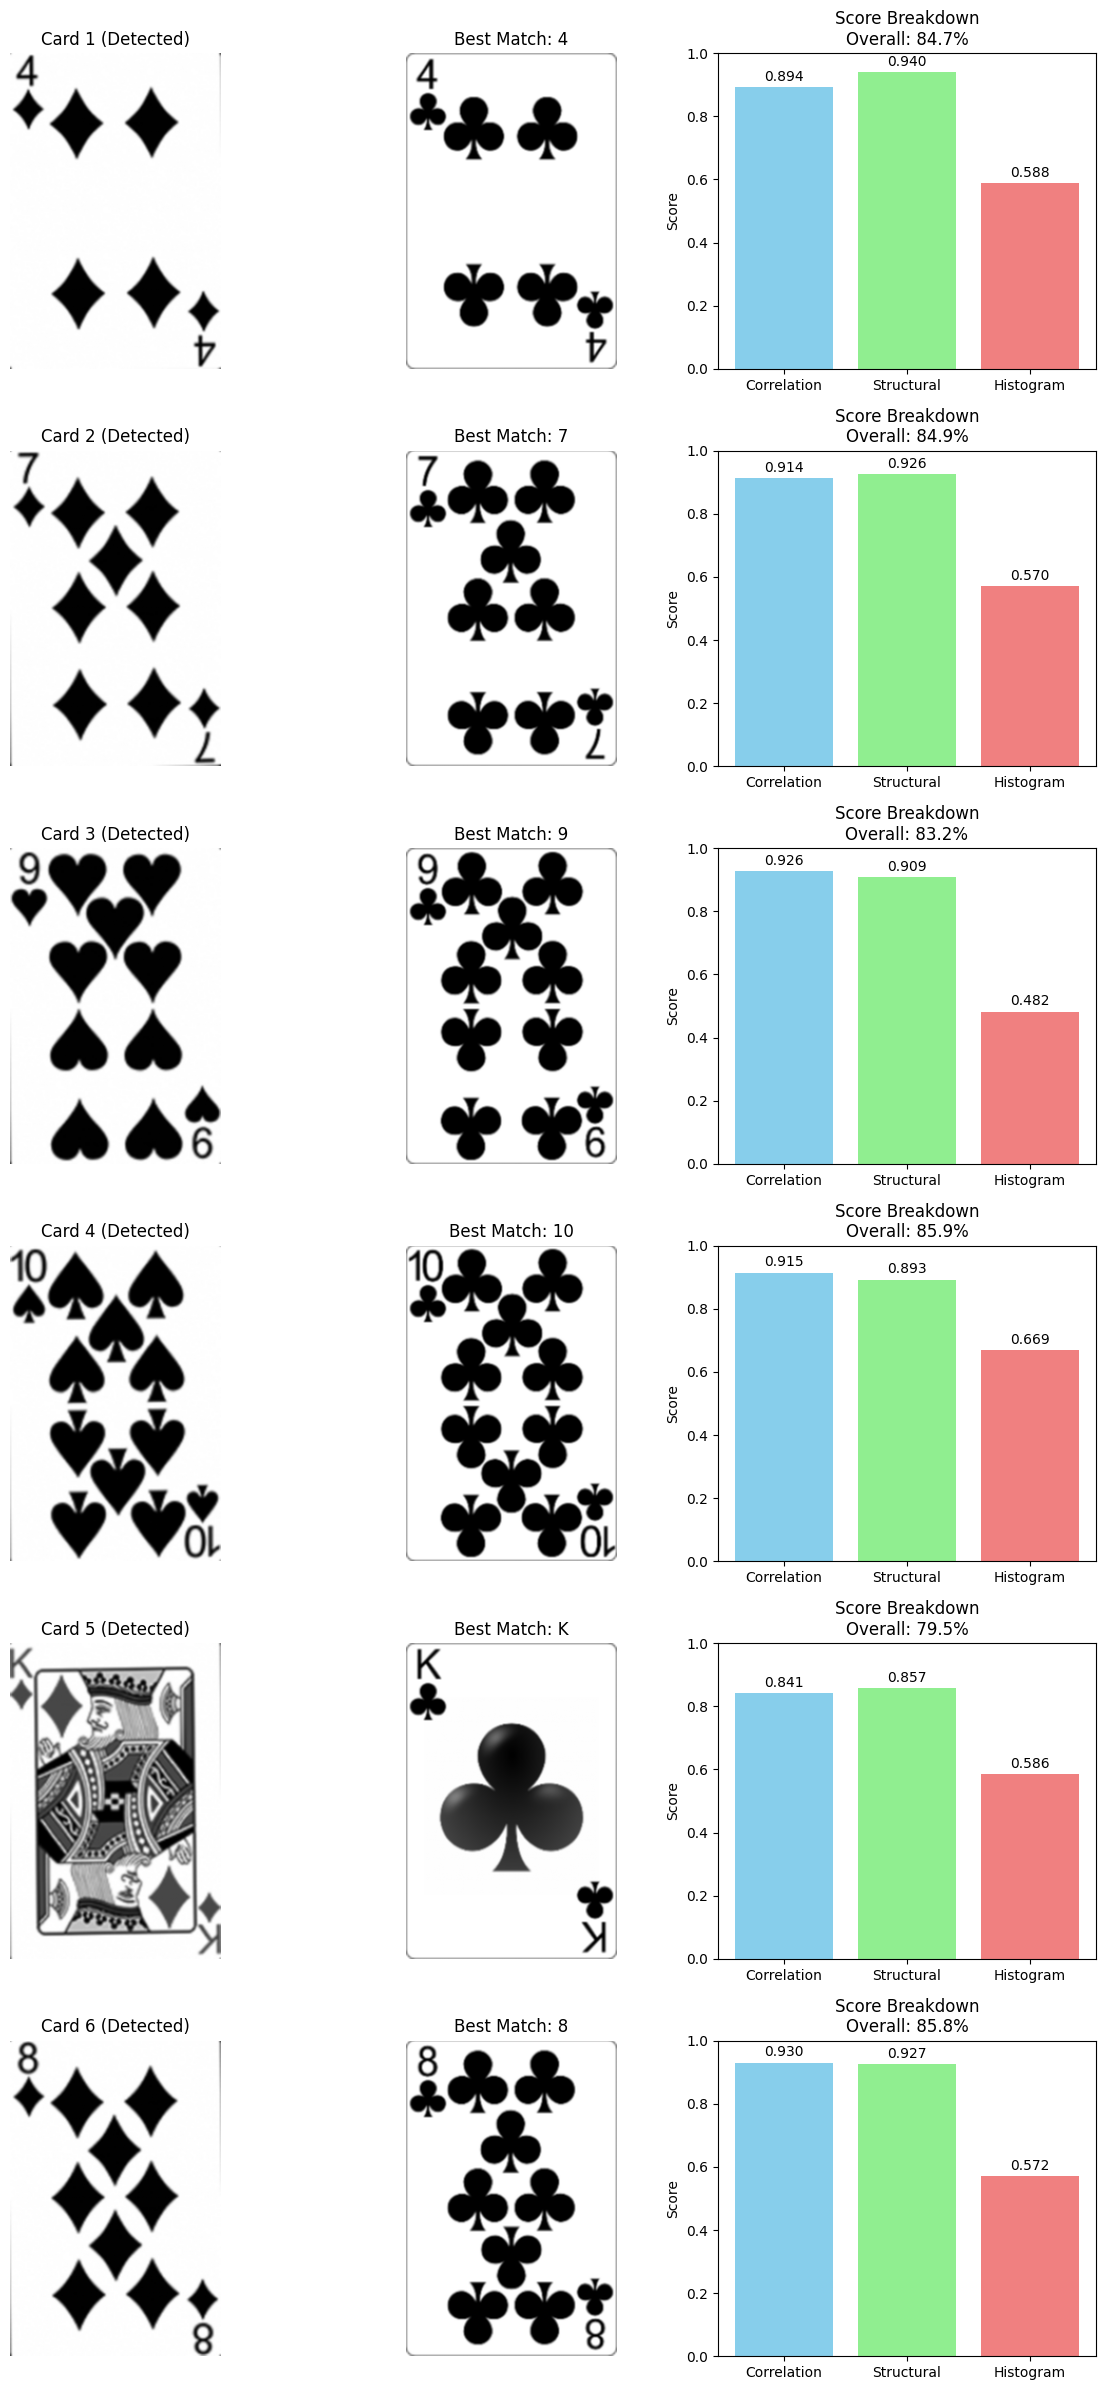


🔍 Debug visualization complete for 6 cards.
Each row shows: [Detected Card] | [Best Template Match] | [Score Breakdown]


In [109]:
# code for subtask 11

# Subtask 11: Visual Debug Info for Whole Card Matching

# Display debug information for each card
fig, axes = plt.subplots(len(match_results), 3, figsize=(12, 4 * len(match_results)))
if len(match_results) == 1:
    axes = axes.reshape(1, -1)

for idx, result in enumerate(match_results):
    # Original processed card
    axes[idx, 0].imshow(processed_cards[idx], cmap='gray')
    axes[idx, 0].set_title(f'Card {idx+1} (Detected)')
    axes[idx, 0].axis('off')
    
    # Best matching template
    best_rank = result['best_rank']
    best_template = card_templates[best_rank][0]  # Show first template of best rank
    axes[idx, 1].imshow(best_template, cmap='gray')
    axes[idx, 1].set_title(f'Best Match: {best_rank}')
    axes[idx, 1].axis('off')
    
    # Score breakdown
    details = result['details']
    scores = [details['corr'], details['struct'], details['hist']]
    labels = ['Correlation', 'Structural', 'Histogram']
    colors = ['skyblue', 'lightgreen', 'lightcoral']
    
    bars = axes[idx, 2].bar(labels, scores, color=colors)
    axes[idx, 2].set_title(f'Score Breakdown\nOverall: {result["best_score"]*100:.1f}%')
    axes[idx, 2].set_ylim(0, 1)
    axes[idx, 2].set_ylabel('Score')
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        axes[idx, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                         f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n🔍 Debug visualization complete for {len(match_results)} cards.")
print("Each row shows: [Detected Card] | [Best Template Match] | [Score Breakdown]")